In [118]:
#1D non-isothermal
#I think we should still convert it to molar flowrates somehow!!!

'''
 - 
'''

from scipy.integrate import solve_bvp
import numpy as np
import matplotlib.pyplot as plt

In [119]:
def heats(T):
    #heats of reaction and heat capacity calculation from NIST
    t = T/1000

    #CH4
    A =	-0.703029
    B =	108.4773
    C =	-42.52157
    D =	5.862788
    E =	0.678565
    F =	-76.84376
    G =	158.7163
    H =	-74.87310

    dH_CH4 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CH4 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2O
    A =   30.09200
    B =   6.832514
    C =   6.793435
    D =  -2.534480
    E =   0.082139
    F =  -250.8810
    G =   223.3967
    H =  -241.8264

    dH_H2O = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2O = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO
    A =   25.56759
    B =   6.096130
    C =   4.054656
    D =  -2.671301
    E =   0.131021
    F =  -118.0089
    G =   227.3665
    H = -110.5271

    dH_CO = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #CO2
    A =   24.99735
    B =   55.18696
    C =  -33.69137
    D =   7.948387
    E =  -0.136638
    F =  -403.6075
    G =   228.2431
    H =  -393.5224

    dH_CO2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_CO2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #H2
    A =  33.066178
    B = -11.363417
    C =  11.432816
    D = -2.772874
    E = -0.158558
    F = -9.980797
    G =  172.707974
    H =  0.0

    dH_H2 = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_H2 = A + B*t + C*t**2 + D*t**3 + E/(t**2)

    #Ar
    A =	20.78600
    B =	2.825911*10**-7
    C =	-1.464191*10**-7
    D =	1.092131*10**-8
    E =	-3.661371*10**-8
    F =	-6.197350
    G =	179.9990
    H =	0

    dH_Ar = A*t + B*t**2/2 + C*t**3/3 + D*t**4/4 - E/t + F - H
    Cp_Ar = A + B*t + C*t**2 + D*t**3 + E/(t**2) #J/mol K

    dHsmr = (3*dH_H2 + dH_CO - dH_CH4 - dH_H2O + 206.1)*10**3 #J/mol
    dHwgs = (dH_H2 + dH_CO2 - dH_CO - dH_H2O - 41.15)*10**3 #J/mol
    # print(dHsmr)
    # print(dHwgs)
    # print([Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2])
    return dHsmr, dHwgs, [Cp_CH4, Cp_H2O, Cp_CO, Cp_CO2, Cp_H2, Cp_Ar], [dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar]

In [120]:
#WANT TO RE-ARANGE CONSTANTS

#reactor constants
L = 0.0609 #m
R_inner = 0.00225 #m outside diameter of inner tube
R_outer = 0.0035 #m inside diameter of outer tube

A = np.pi * ((R_outer)**2-(R_inner)**2) #m^2 AXIAL AREA (GAS FLOW)
V = A*L #m^3
S = 2*np.pi*R_outer*L #m^2 RADIAL AREA (HEAT FLUX AND REACTION)

Peri = 2*np.pi*R_outer

#gas flow constants WHEN CHANGING THE TEMPERATURE YOU NEED TO ADJUST THE INITIAL GUESS -- USING ODEINT MIGHT BE FOR BETTER CONVERSION
Tin = 900 #K
P = 1 #bar or atm
Rgas = 8.3144598 * 10**-5

sccm0 = np.array([16.16, 48.48, 0, 0, 10, 5])
mols0 = sccm0/22400 /60
boundary = np.concatenate((mols0, [Tin]))
print(boundary)
#rate equation constants
Rreact = 8.314 #J / mol·K
Easmr = 165.740 #kJ/mol
Asmr = 1.68*10**8
Eawgs = 89.23 #kJ/mol
Awgs = 9.90*10**3

Ku = 1

I = 9 #curent in Amps
Fa = 96485 #faradays constant
h2Rem = 1

U = 20 #W/m2 K
Ts = 298 #K

q_furn = 15000 #W/m2 K

MM = np.array([16.04, 18.01528, 28.01, 44.009, 2.016, 39.948])
m0 = np.dot(MM, mols0)
print(m0) #kg/s

print(np.sum(mols0))

[1.20238095e-05 3.60714286e-05 0.00000000e+00 0.00000000e+00
 7.44047619e-06 3.72023810e-06 9.00000000e+02]
0.0010063148619047619
5.925595238095239e-05


In [121]:
x_num = 1000
dx = L/(x_num-1)

x_pts = np.linspace(0,L,x_num)

#initial guess array
init_guess = np.zeros((7, x_num))
init_guess[0, :] = boundary[0]
init_guess[1, :] = boundary[1]
init_guess[2, :] = boundary[2]
init_guess[3, :] = boundary[3]
init_guess[4, :] = boundary[4]  
init_guess[5, :] = boundary[5]
init_guess[6, :] = boundary[6]


def odes(x, F):
    y = F[:6]/np.sum(F[:6], axis = 0)
    T = F[6]
    Ctot = P/(Rgas * T)

    global vfinal
    v = np.sum(F[:6], axis = 0)/Ctot / A #m/sec
    vfinal = v

    Keqsmr = (101325/100000)**2 * np.exp(-26830/T + 30.114)
    Keqwgs = np.exp(4400/T - 4.036)

    rsmr = np.full(len(y[0]), 2) #S/V*Ku*Asmr*np.exp(-Easmr*1000/Rreact/T)*(y[0]*y[1]-(P**2)*y[2]*(y[4]**3)/Keqsmr)
    rwgs = np.full(len(y[0]), 2) #S/V*Ku*Awgs*np.exp(-Eawgs*1000/Rreact/T)*(y[1]*y[2]-y[3]*y[4]/Keqwgs)
    #rh2r = I/(2*Fa*L) #have not confirmed if this is correct

    dHsmr, dHwgs, Cps, _ = heats(T)
    Cpg = np.sum(y[:6, :]*Cps, axis=0)

    Fch4 = (-rsmr)*A
    Fh2o = (-rsmr - rwgs)*A
    Fco = (rsmr - rwgs)*A
    Fco2 = (rwgs)*A
    Fh2 = (3*rsmr + rwgs)*A # - h2Rem*rh2r
    Far = np.zeros(len(y[0]))
    Temp = (Peri*U*(-T[:] + Ts) - A*(dHsmr*rsmr + dHwgs*rwgs) + q_furn*Peri)/(np.sum(F[:6], axis = 0)*Cpg)

    return np.vstack([Fch4, Fh2o, Fco, Fco2, Fh2, Far, Temp])

def bcs(yleft, yright):
    return np.array(yleft-boundary)

soln = solve_bvp(odes, bcs, x_pts, init_guess, max_nodes=50, tol = 0.01)

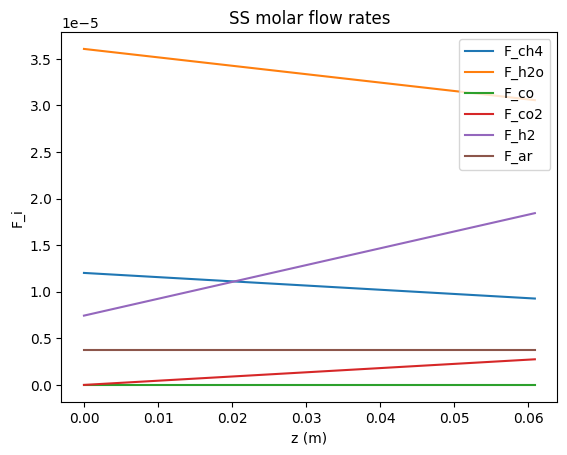

In [122]:
plt.plot(soln.x, soln.y[0], label='F_ch4')
plt.plot(soln.x, soln.y[1], label='F_h2o')
plt.plot(soln.x, soln.y[2], label='F_co')
plt.plot(soln.x, soln.y[3], label='F_co2')
plt.plot(soln.x, soln.y[4], label='F_h2')
plt.plot(soln.x, soln.y[5], label='F_ar')
plt.xlabel('z (m)')
plt.ylabel('F_i')
plt.title('SS molar flow rates')
plt.legend()

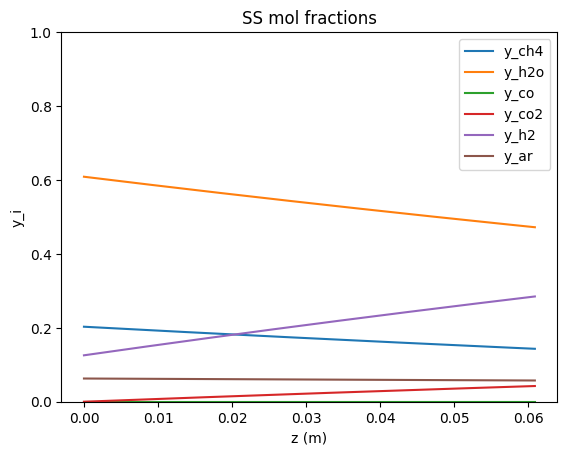

In [123]:
y = soln.y[:6]/np.sum(soln.y[:6], axis = 0)
plt.plot(soln.x, y[0], label='y_ch4')
plt.plot(soln.x, y[1], label='y_h2o')
plt.plot(soln.x, y[2], label='y_co')
plt.plot(soln.x, y[3], label='y_co2')
plt.plot(soln.x, y[4], label='y_h2')
plt.plot(soln.x, y[5], label='y_ar')
plt.ylim(0, 1)
plt.xlabel('z (m)')
plt.ylabel('y_i')
plt.title('SS mol fractions')
plt.legend()

Text(0.5, 1.0, 'Temperature profile')

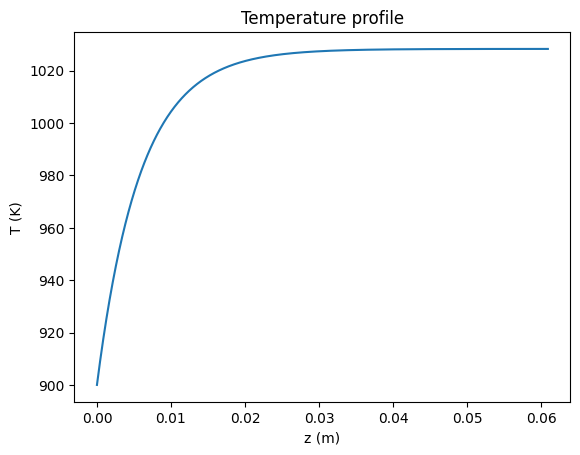

In [124]:
plt.plot(soln.x, soln.y[6])
plt.xlabel('z (m)')
plt.ylabel('T (K)')
plt.title('Temperature profile')

In [125]:
mf = np.dot(MM, soln.y[:6,-1])

print(f'{m0:.4e}')
print(f'{mf:.4e}')
print(f'mass balance off by {abs(mf - m0)/mf *100:.3e}%')

1.0063e-03
1.0063e-03
mass balance off by 6.668e-04%


In [126]:
#Enthalpy balance based on heats of formation
_, _, _, heatsin = heats(soln.y[6,0])
_, _, _, heatsout = heats(soln.y[6,-1])

Qarray = U*(-soln.y[6]+Ts)*Peri*dx + q_furn*Peri*dx
Q = np.sum(Qarray)

#[dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar] # kJ/mol
Hin = np.sum((heatsin + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))*10**3 *soln.y[:6,0])
Hout = np.sum((heatsout + np.array([-74.5, -241.8, -110.5, -393.52, 0, 0]))*10**3 *soln.y[:6,-1])

print(Q/S)

dH = Hout-Hin
print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

645.7959690981725
0.862 W
0.865 W
heat balance off by 0.3779%


999
1000


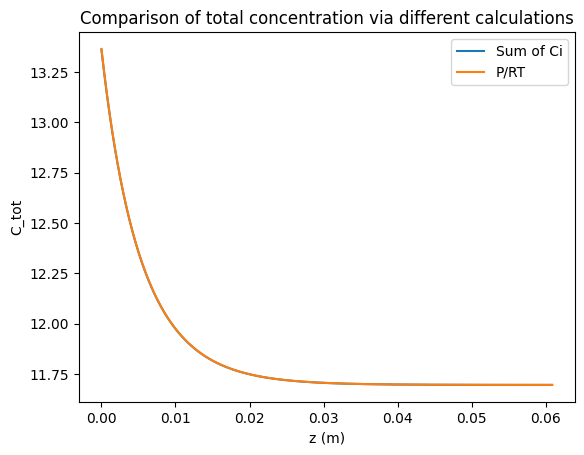

In [127]:
u = vfinal * A
print(len(u))
print(len(soln.y[0]))
Csum = np.sum(soln.y[:6,:len(u)], axis = 0)/u

T = soln.y[6]
plt.plot(soln.x[:len(Csum)], Csum, label='Sum of Ci')
plt.plot(soln.x, P/(Rgas * T), label='P/RT')
plt.xlabel('z (m)')
plt.ylabel('C_tot')
plt.title(f'Comparison of total concentration via different calculations')
plt.legend()

Text(0.5, 1.0, 'Velocity profile along reactor')

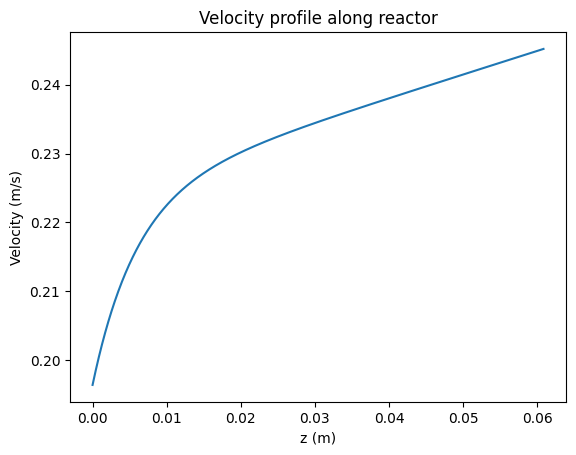

In [128]:
v = vfinal
plt.plot(soln.x[:len(v)], v)
plt.xlabel('z (m)')
plt.ylabel('Velocity (m/s)')
plt.title(f'Velocity profile along reactor')

In [129]:
#heat balance with the absolute enthalpy IS NOT GOOD FOR WHEN REACTIONS
_, _, _, heatsin = heats(soln.y[6,0]) #kJ/mol
_, _, _, heatsout = heats(soln.y[6,-1]) #kJ/mol

#[dH_CH4, dH_H2O, dH_CO, dH_CO2, dH_H2, dH_Ar] # kJ/mol
print(heatsin + np.array([9.857, 9.904, 8.669, 9.364, 8.393, 0]))
Hin = np.sum((heatsin + np.array([9.857, 9.904, 8.669, 9.364, 8.393, 0]))*10**3 *soln.y[:6,0])
Hout = np.sum((heatsout + np.array([9.857, 9.904, 8.669, 9.364, 8.393, 0]))*10**3 *soln.y[:6,-1])
dH = Hout-Hin
print(dH) #W

print(f'{dH:.3} W')
print(f'{Q:.3} W')
print(f'heat balance off by {abs(dH - Q)/Q *100:.4}%')

[41.06186158 31.84318924 27.06850602 37.39578507 26.0691085  12.51005012]
0.44548067883563025
0.445 W
0.865 W
heat balance off by 48.49%


Sorry, we don’t have experimental data for that temperature.


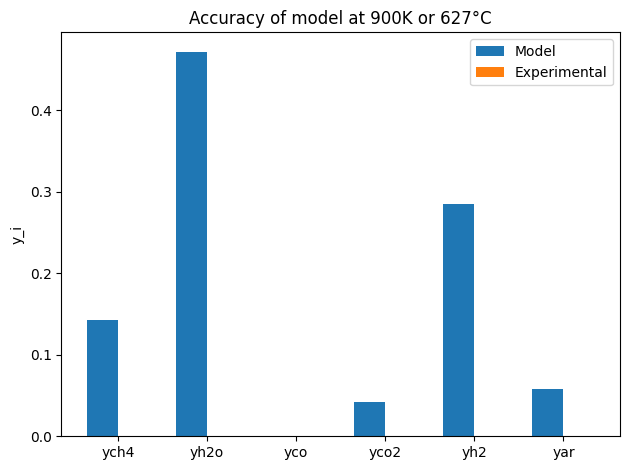

1000.0000000000001


In [130]:
# Assign experimental data based on temperature
if Tin == 622 + 273:
    yexp = [0.071787506, 0.298008466, 0.043658696, 0.043658696, 0.495104008, 0.047782628]
elif Tin == 721 + 273:
    yexp = [0.019206098, 0.189598069, 0.090570208, 0.034350264, 0.619497555, 0.046777807]
elif Tin == 573 + 273:
    yexp = [0.101830373, 0.416886827, 0.02267593, 0.043676434, 0.365008486, 0.04992194]
elif Tin == 522 + 273:
    yexp = [0.135048125, 0.331577273, 0.010516725, 0.034486466, 0.436794105, 0.051577306]
else:
    print('Sorry, we don’t have experimental data for that temperature.')
    yexp = [0, 0, 0, 0, 0, 0]


# Define categories
categories = ['ych4', 'yh2o', 'yco', 'yco2', 'yh2', 'yar']
x = np.arange(len(categories))  # the label locations
width = 0.35  # the width of the bars

# Plot
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, soln.y[:6,-1]/np.sum(soln.y[:6,-1]), width, label='Model')
bars2 = ax.bar(x + width/2, yexp, width, label='Experimental')

# Labels and legend
ax.set_ylabel('y_i')
ax.set_title(f'Accuracy of model at {Tin}K or {Tin - 273}°C')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

plt.tight_layout()
plt.show()

print(np.sum(y))